# U.S. HOUSE ELECTION PREDICTION
---
We model the biannual elections for the United States House of Representatives using a Bayesian model based on informative priors and generic congressional ballot polling.

# Model

Our eventual goal is to estimate the difference in vote share for the Democratic and Republican candidates in each of the four hundred thirty five congressional races. We cannot observe this directly; we must infer it from a combination of structural factors such as economic conditions and incumbency, and polling data, usually from a "generic congressional ballot."

## Poll Aggregation
We first look backwards, aggregating generic congressional ballot polls.

For each poll $i$:
- The sample size is denoted $N_i$.
- The time at which the poll was conducted is denoted $t_i$. Time is discretized on a weekly basis.
- The polling firm conducting the poll is denoted $p_i$.

A generic congressional ballot poll measures the number of respondents who say they would vote for each party's House candidate. The number of respondents choosing the Democrat is $N_i^D$, which is drawn from a Binomial distribution,
$$ N_i^D \sim \mathrm{Binomial}(N_i, \pi_i+0.5) $$
where $\pi_i$ is the margin of support for the Democrats over the Republicans
in this poll.  Why not use $\mu$? Pollsters sample differently and have different methodologies, and so the margin of support they measure is different from the true margin.

Various factors contribute to the margin of support measured in a particular poll.  There is pollster-specific error and bias, sampling error, and statewide polling error (shared by all polling firms). So we can decompose $\pi_i$ into  components,
$$
\mathrm{logit}(\pi_i) = \mu[t_i] + \alpha_p[p_i] + \alpha_n + \epsilon,
$$
where $\alpha_p$ is pollster-specific error, $\alpha_n$ is national polling error, amd $\epsilon$ is sampling error. Polling firms can be biased towards either party:
$$ \begin{align}
    \alpha_p[p_i] &\sim \mathrm{Normal}(0, \sigma_p) \\
    \sigma_p &\sim \mathrm{Uniform}(0, 10\%)
\end{align} $$
National polling error can also go either way. We use the historical bias as our prior (average bias of 2.70% and a standard deviation in bias of 5.63%):
$$ \begin{align}
    \alpha_n &\sim \mathrm{Normal}(2.70\%, \sigma_n) \\
    \log(\sigma_n) &\sim \mathrm{Normal}(\log(5.63\%), 2)
\end{align} $$
$$ \alpha_n \sim \mathrm{Normal}(2.7\%, \sigma_n31.6\%^2) $$
Measurement noise is normally distributed around zero, with a standard error $\sigma_e$ having a uniform distribution between 0 and 10%.

To smooth out changes in polling and to obtain polling estimates for weeks in which no results are released, we use a reverse random walk prior for $\mu$:
$$ \mu[t-1] \sim \mathrm{Normal}(\mu[t], \sigma). $$
We assume a uniform prior for $\sigma$ between 0 and 10%.  This smoothing is also caried forward towards election day.

## National Vote Margin Forecasting
We use a normal distribution as our prior for the final vote margin. The mean and variance of the distribution come from a linear model:
$$
\mathbf{E}(\mu[T]) = a_0 + a_1APPR + a_2INC\times PRES + a_3PRES\times MID + e_a,
$$
where $T$ is Election Day, $INC$ a categorical variable representing the incumbent majority party ($+1$ for the Democrats, $-1$ for the Republicans), $PRES$ is the sitting president's party (1 for a Democrat, $-1$ for a Republican), $APPR$ is the average of sitting president's approval rating from January to June before the election, and $MID$ represents whether the election is a midterm (1 if it is, 0 if not). So we calculate $MRG$ for this election, and use the MSE of the regression as our estimate for variance.

## House Race Forecasting
We use a linear model to forecast each house race $\mu_r$:
$$
\mathbf{E}(\mu_r[T]) = \mathrm{Multivariate\ Normal}(\mathrm{logit}(
b_0 + b_1\mu[T] + b_2INC_r + b_3PVI_r + b_4PVI_r\times PRES + e_b), \mathbf{\Sigma}),
$$
where $INC_r$ is a categorical variable representing the incumbent in the race ($+1$ for a Democrat, $-1$ for a Republican, and 0 for an open seat), and $PVI$ is the partisan voting index of the district. For the covariance matrix $\mathbf{\Sigma}$, we use historical values for the variance (0.019) and covariance (0.0040) for each district and pair of districts.  This gives about at 20% correlation between the errors in each district.

The winner of each race is simply $\mathrm{sgn}(\mu_r[T])$, and the final seat margin in the U.S. House is 
$$ \sum_r \mathrm{sgn}(\mu_r[T]). $$

# Setup

In [472]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

from urllib.request import urlopen as fetch
from bs4 import BeautifulSoup
import re
from datetime import date
from IPython.display import display


import matplotlib
import seaborn as sb
from pylab import rcParams
rcParams["figure.figsize"] = 10, 7
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
election_day = date(2018, 11, 6)

# Data

##  GDP Growth
The yearly percentage change in  real GDP.

In [3]:
from fredapi import Fred

FRED = Fred("75d3a2383e8806d7b956a4849aff66a9")
gdp_growth = FRED.get_series('A191RL1A225NBEA', observation_start='1940-01-01')

## Presidential Approval Ratings

In [4]:
from dateutil.relativedelta import relativedelta

approvals = pd.read_table("data/approval.csv")
approvals = approvals[["Approving", "President", "Week Ending Date"]]
approvals.rename(columns={
    "Approving": "approval", 
    "President": "president", 
    "Week Ending Date": "date"}, 
                 inplace=True)

approvals.date = pd.to_datetime(approvals.date)

approvals.loc[approvals.date >= pd.to_datetime("1/1/2020"), "date"] -= np.timedelta64(100, "Y")
approvals.sort_values("date", inplace=True)

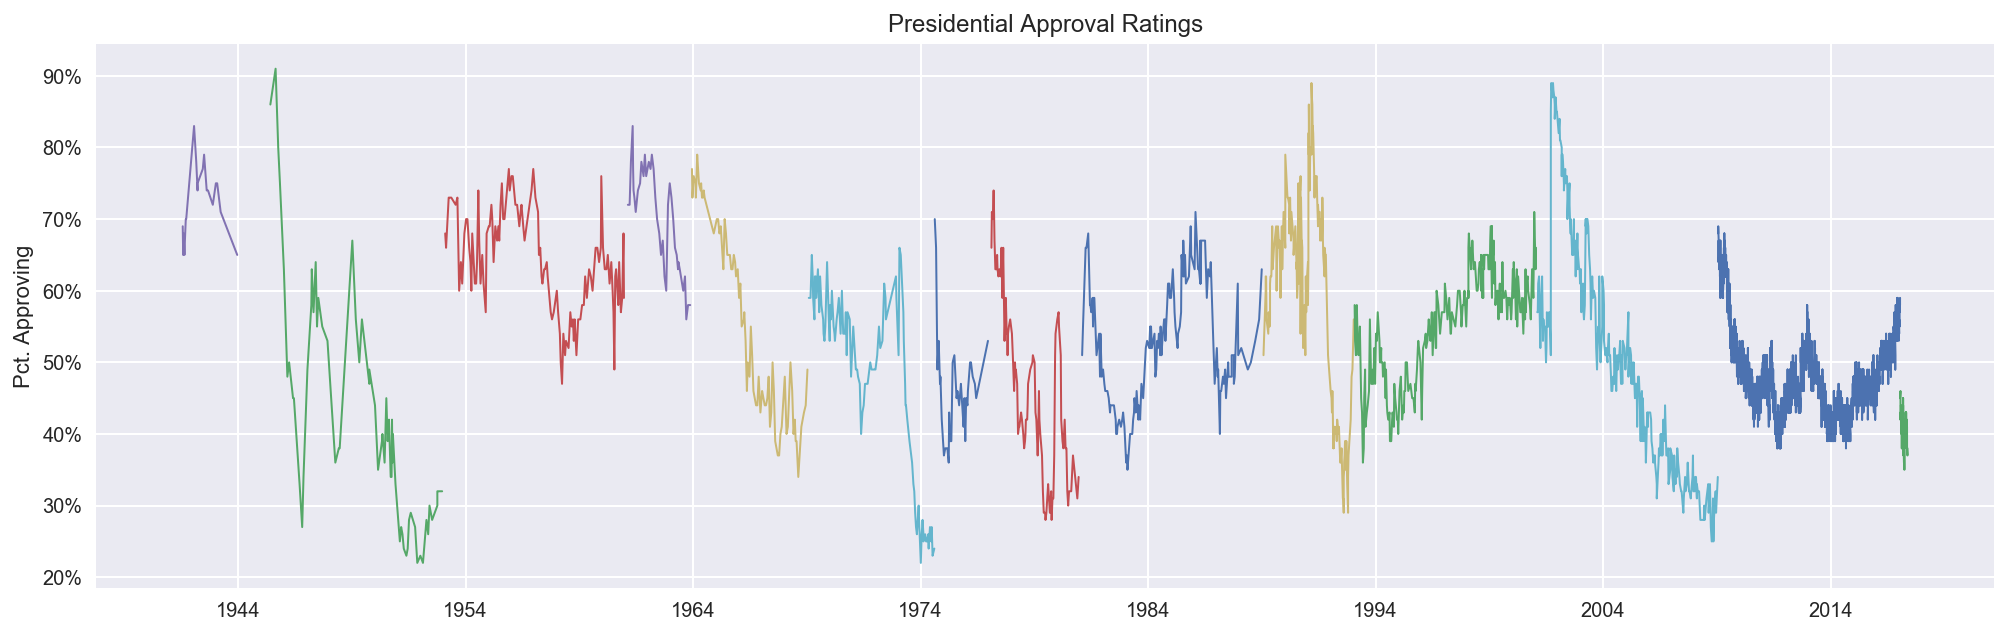

In [5]:
plt.figure(figsize=(17,5))
for president, data in approvals.groupby("president"):
    plt.plot(data.date, data.approval, linewidth=1, label=president)
    
plt.title("Presidential Approval Ratings")
plt.ylabel("Pct. Approving")
plt.gca().set_yticklabels([f"{x}%" for x in range(10, 110, 10)]);

## Incumbents

In [6]:
import us

def name_to_abbr(name):
    return us.states.lookup(name).abbr

In [7]:
def find_not_running(year):
    page = fetch(f"https://en.wikipedia.org/wiki/United_States_House_of_Representatives_elections,_{year}")
    soup = BeautifulSoup(page)
    # find the section that mentions retiring incumbents
    incumbents = soup.find("span", class_="mw-headline", string=re.compile("incumbent", re.I)).parent
    not_running = []
    # there is a list for each party
    for l in incumbents.find_next_siblings("ol"):
        for item in l.find_all("li"):
            # each item is like 'Arizona 1: John Smith.' We extract the state and district # 
            state, district = item.get_text().split(":")[0].split("\xa0")
            district = 0 if district.lower() == "at-large" else int(district)
            not_running.append(f"{name_to_abbr(state)}-{district:02}")

    return not_running

In [8]:
def get_incumbency():
    data = []
    
    page = fetch("https://en.wikipedia.org/wiki/Current_members_of_the_United_States_House_of_Representatives")
    soup = BeautifulSoup(page)
    
    heading = soup.find("span", id="Voting_members_by_state").parent
    table = heading.find_next_sibling("table")
   
    first = True
    for row in table.find_all("tr"):
        # skip first row (headings)
        if first:
            first = False
            continue
            
        district, _, _, party, *_ = [c.text for c in row.find_all("td")]
        state, district = re.split(' (?=at large|\d)', district.lower())
        district = 0 if district == "at large" else int(district)
        party = 1 if party == "Democratic" else -1 if party == "Republican" else 0
        
        data.append({
            "district": f"{name_to_abbr(state)}-{district:02}",
            "incumbent": party
        })
    
    return pd.DataFrame(data).sort_values("district").set_index("district", drop=False)

## Cook PVI

We will calculate our own PVI ratings. We cheat a little and only use one prior election for the 2004 PVIs since that will give us two more elections' worth of data. We cannot find PVIs for the 2000 election.

In [9]:
cd_vote = pd.read_table("data/cd_president.tsv")
# national presidential popular vote margin
national_margin = {
    2000: 0.5,
    2004: -2.7,
    2008: 7.2,
    2012: 3.9,
    2016: 2.1
}

cd_vote["pres_margin_00"] = cd_vote.dem_00 - cd_vote.gop_00
cd_vote["pres_margin_04"] = cd_vote.dem_04 - cd_vote.gop_04
cd_vote["pres_margin_08"] = cd_vote.dem_08 - cd_vote.gop_08
cd_vote["pres_margin_12"] = cd_vote.dem_12 - cd_vote.gop_12
cd_vote["pres_margin_16"] = cd_vote.dem_16 - cd_vote.gop_16


cd_vote["pvi_2002"] = cd_vote.pres_margin_00 - national_margin[2000] / 2
cd_vote["pvi_2006"] = ((cd_vote.pres_margin_04 - national_margin[2004]) 
                       + (cd_vote.pres_margin_00 - national_margin[2000])) / 4
cd_vote["pvi_2010"] = ((cd_vote.pres_margin_08 - national_margin[2008]) 
                       + (cd_vote.pres_margin_04 - national_margin[2004])) / 4
cd_vote["pvi_2014"] = ((cd_vote.pres_margin_12 - national_margin[2012]) 
                       + (cd_vote.pres_margin_08 - national_margin[2008])) / 4
cd_vote["pvi_2018"] = ((cd_vote.pres_margin_16 - national_margin[2016]) 
                       + (cd_vote.pres_margin_12 - national_margin[2012])) / 4

cd_vote.set_index("race", drop=False, inplace=True)

## Historical House Race Results

In [10]:
def get_results(year):
    url = f"http://openelections.github.io/fec_results/api/{year}/congress/results.json"
    raw = fetch(url).read().decode("utf-8")

    formatted = re.sub(r'\\\\\\"', "'", raw)
    formatted = re.sub(r'(?<!\\)"', "", formatted)
    formatted = re.sub(r'\\', "", formatted)
    
    data = pd.read_json(formatted, orient="records")
    
    data = data[data.chamber == "H"]
    data.drop(["candidate_suffix", "chamber", "date", "fec_id", "notes", 
               "general_combined_party_pct", "general_combined_party_votes"], 
           axis=1, inplace=True)
    
    data.party = data.party.map(str.strip)
    
    # drop DC and territories
    data = data[~data.state.isin(["DC", "AS", "PR", "VI", "GU", "MP"])]
    
    # drop primary candidates
    data.dropna(subset=["general_pct"], inplace=True)
    
    # use runoff pct. where they exist
    data["pct"] = data.runoff_pct
    data[np.isnan(data.pct)].pct = data[np.isnan(data.pct)].general_pct
    
    data.district = data.district.map(lambda x: x[:2]) # the first 2 characters contain the number
    data.district = pd.to_numeric(data.district, errors="coerce")
    data.dropna(subset=["district"], inplace=True)
    data.district = data.district.map(int)    
    
    data["race"] = data.state + "-" + data.district.map("{:0>2}".format)
    
    return data

## Generic Congressional Ballot Polling

Average bias: 2.70%
Bias std. dev.: 5.63%
                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     44.46
Date:                Mon, 19 Jun 2017   Prob (F-statistic):           4.37e-11
Time:                        18:58:12   Log-Likelihood:                -3020.2
No. Observations:                 967   AIC:                             6044.
Df Residuals:                     965   BIC:                             6054.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept 

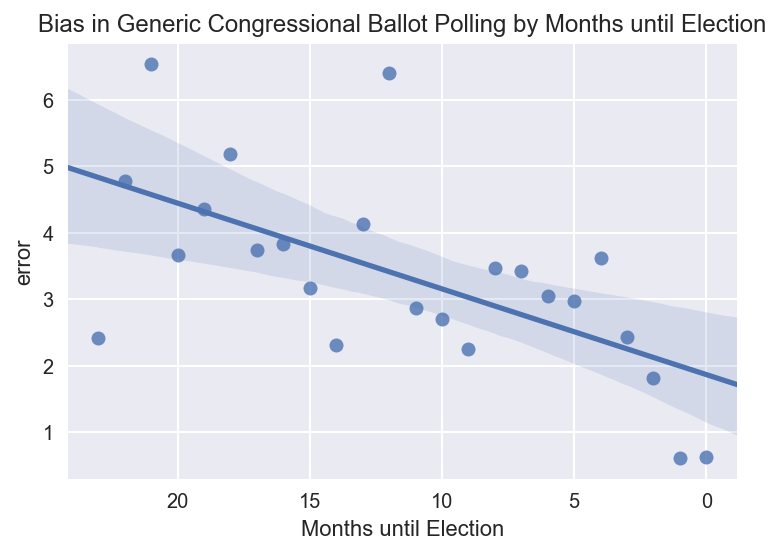

In [314]:
generic = pd.read_table("data/generic_polling.tsv")
generic["abs_error"] = np.abs(generic.error)
bias_by_month = generic.groupby("months").error.mean()
error_by_month = generic.groupby("months").abs_error.mean()
months = np.arange(len(error_by_month))

# how polling avg in final month compared to end result
error_by_year = generic[generic.months == 0].groupby("year").error.mean().to_dict()
# manually add error for years we don't have polling data
error_by_year[2004] = 2.9
error_by_year[2002] = 2.6

avg_final_bias = (generic.error / 100).mean()
final_bias_std = (generic.error / 100).std()

print(f"Average bias: {avg_final_bias:.2%}")
print(f"Bias std. dev.: {final_bias_std:.2%}")

fig = sb.regplot(months, bias_by_month)
fig.invert_xaxis()
plt.title("Bias in Generic Congressional Ballot Polling by Months until Election")
plt.xlabel("Months until Election")

bias_model = smf.ols("error ~ months", data=generic).fit()
print(bias_model.summary())

## National Prior Model

In [636]:
years = range(1992, 2016, 2)

# party of sitting president in each year (1 for Democrat)
president_series = [-1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1]
incumbency_series = [1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1]
nat_margin_series = [5.0, -7.1, 0.07, -1.1, -0.5, -4.8, -2.6, 7.9, 10.6, -6.8, 1.2, -5.7]
midterm_series = []
gdp_series = []
approval_series = []

for year in years:
    
    gdp_series.append(gdp_growth.loc[f"{year - 1}-01-01"])
    approval = approvals[(date(year, 1, 1) < approvals.date)
                         & (approvals.date < date(year, 6, 1))].approval.mean()
    approval_series.append(approval)
    midterm_series.append(0 if year % 4 == 0 else 1)
    

ndata = pd.DataFrame({"GDP": gdp_series, "APPR": approval_series,
                    "INC": incumbency_series, "MRG": nat_margin_series,
                    "PRES": president_series, "MID": midterm_series, 
                     "YR": range(-len(years), 0)}, index=years)

In [640]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

n = len(data)

nat_prior = smf.ols("MRG ~ APPR + INC:PRES + PRES:MID", data=ndata).fit()
print(nat_prior.summary())

                            OLS Regression Results                            
Dep. Variable:                    MRG   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     10.50
Date:                Mon, 19 Jun 2017   Prob (F-statistic):            0.00379
Time:                        21:12:42   Log-Likelihood:                -27.861
No. Observations:                  12   AIC:                             63.72
Df Residuals:                       8   BIC:                             65.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.3039      3.927      3.388      0.0

## House Race Model

### Data Preparation

In [14]:
years = range(2002, 2016, 2)

incumbency_series = []
margin_series = []
nat_series = []
pvi_series = []
district_series = []
president_series = []
midterm_series = []
years_series = []
# party of sitting president in each year (1 for Democrat)
president = {
    2000: 1,
    2002: -1,
    2004: -1,
    2006: -1,
    2008: -1,
    2010: 1,
    2012: 1,
    2014: 1,
}

for year in years:
    results = get_results(year)
    
    if year % 4 == 0: # presidential election year
        pvi_string = f"pvi_{year - 2}"
    else:
        pvi_string = f"pvi_{year}"
    
    for race, row in results.groupby("race"):
        dem = row[(row.party == "D") | (row.party == "DFL") | (row.party == "D*")
                 | (row.party == "DEM") | row.party.str.contains("D/") | row.party.str.contains("DEM/")]
        gop = row[(row.party == "R") | (row.party == "R*")| (row.party == "REP")
                 | row.party.str.contains("R/") | row.party.str.contains("REP/")]
        
        # uncontested seat
        if len(dem) == 0:
            incumbent = -1 if gop.iloc[0].incumbent else 0
            margin = np.nan
        elif len(gop) == 0: 
            incumbent = 1 if dem.iloc[0].incumbent else 0
            margin = np.nan
        else:
            margin = dem.general_pct.sum() - gop.general_pct.sum()
            incumbent = 1 if dem.iloc[0].incumbent else -1 if gop.iloc[0].incumbent else 0
        
        
        margin_series.append(margin)
        incumbency_series.append(incumbent)
        pvi_series.append(cd_vote.loc[cd_vote.race == race, pvi_string].item())
        district_series.append(race)
        president_series.append(president[year])
        midterm_series.append(0 if year % 4 == 0 else 1)
        years_series.append(year)
        
        idx = (year - 2016) // 2
        nat_series.append(error_by_year[year])

In [15]:
data = pd.DataFrame({"INC": incumbency_series, "MRG": margin_series,
                    "PVI": pvi_series, "DIST": district_series,
                    "PRES": president_series, "MID": midterm_series,
                    "NAT": nat_series, "WIN": np.sign(margin_series),
                     "YR": (np.array(years_series) - 2016)/2}, 
                    index=years_series)
data_clean = data.dropna()
data_clean.head()

,DIST,INC,MID,MRG,NAT,PRES,PVI,WIN,YR
2002,AK-00,-1,1,-57.230431,2.6,-1,-31.25,-1.0,-7.0
2002,AL-01,0,1,-22.718497,2.6,-1,-22.25,-1.0,-7.0
2002,AL-02,-1,1,-39.229644,2.6,-1,-23.25,-1.0,-7.0
2002,AL-03,0,1,-2.106797,2.6,-1,-5.25,-1.0,-7.0
2002,AL-05,1,1,48.574327,2.6,-1,-10.25,1.0,-7.0


                            OLS Regression Results                            
Dep. Variable:                    MRG   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2880.
Date:                Mon, 19 Jun 2017   Prob (F-statistic):               0.00
Time:                        16:12:31   Log-Likelihood:                -10685.
No. Observations:                2592   AIC:                         2.138e+04
Df Residuals:                    2587   BIC:                         2.141e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0618      0.362      0.170      0.8

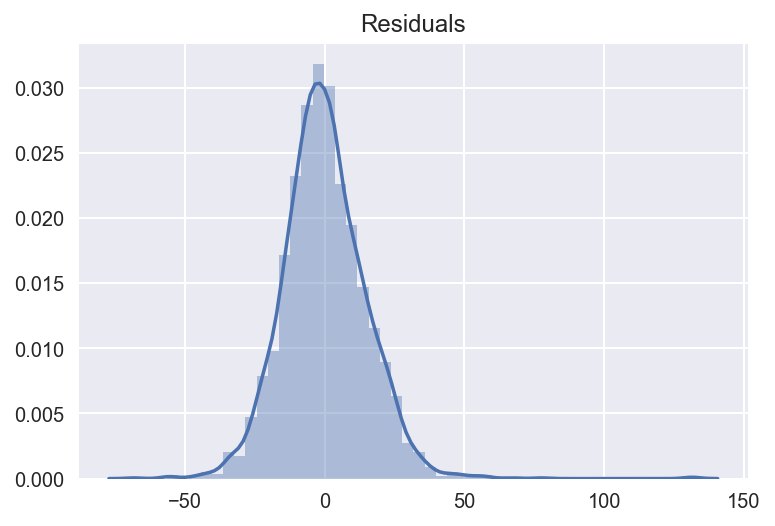

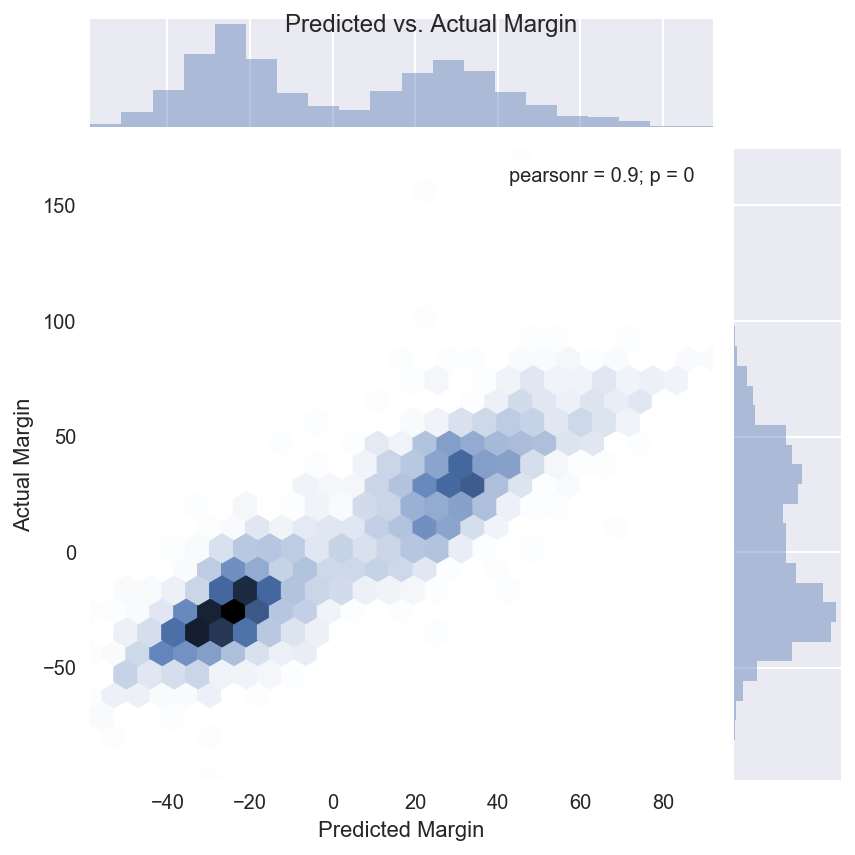

In [16]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

n = len(data_clean)

prior_model = smf.ols("MRG ~ NAT + PVI + INC + PVI:PRES", data=data_clean).fit()
print(prior_model.summary())

sb.distplot(prior_model.resid)
plt.title("Residuals")

(sb.jointplot(prior_model.fittedvalues, data_clean.MRG, kind="hex")
    .set_axis_labels("Predicted Margin", "Actual Margin"))
plt.suptitle("Predicted vs. Actual Margin");

In [17]:
data_clean["resid"] = prior_model.resid / 100
by_district = data_clean.pivot(columns="DIST", values="resid")
by_district.dropna(axis=1, inplace=True)

district_cov = np.cov(by_district.values.transpose())

dist_var = np.mean(district_cov.diagonal())
dist_cov = np.mean(np.extract(1 - np.identity(200), district_cov))

print(f"VAR: {dist_var:.4f}")
print(f"COV: {dist_cov:.4f}")
print(f"r = {dist_cov / dist_var:.3}")

VAR: 0.0183
COV: 0.0040
r = 0.218


In [18]:
pred = np.sign(prior_model.fittedvalues)
act = np.sign(data_clean.MRG)

data_clean["correct"] = (pred == act)

true_dem = sum((pred == act) & (pred == 1))
true_gop = sum((pred == act) & (pred == -1))
false_dem = sum((pred != act) & (pred == 1))
false_gop = sum((pred != act) & (pred == -1))


accuracy = sum(pred == act) / n

print(f"Accuracy:\t{accuracy:.1%}")
print()
print(" \tPredicted")
print("Actual\tDEM\tGOP\tTotal")
print(f"DEM\t{true_dem}\t{false_gop}\t{true_dem+false_gop}")
print(f"GOP\t{false_dem}\t{true_gop}\t{false_dem+true_gop}")
print(f"Total\t{true_dem+false_dem}\t{true_gop+false_gop}\t{n}")

Accuracy:	92.3%

 	Predicted
Actual	DEM	GOP	Total
DEM	1142	94	1236
GOP	105	1251	1356
Total	1247	1345	2592


# Polling

In [20]:
import pollster
pollster = pollster.Api()

In [758]:
election_day = date(2018, 11, 6)

polls = pollster.questions_slug_poll_responses_clean_tsv_get("18-US-House")
polls = polls[polls.sample_subpopulation.isin(["Likely Voters", "Registered Voters"])]
polls.rename(columns={"observations": "n_resp"}, inplace=True)

polls["n_dem"] = polls.Democrat / (polls.Democrat + polls.Republican) * polls.n_resp
polls.dropna(subset=["n_dem"], inplace=True)
polls.n_dem = polls.n_dem.astype("int")
polls.n_resp = polls.n_resp.astype("int")

polls["pollster"] = pd.factorize(polls.survey_house)[0] + 1
weeks = (election_day - polls.start_date).apply(lambda x: int(x.days / 7))
months = (election_day - polls.start_date).apply(lambda x: int(x.days / 30.4375))
n_weeks = weeks.max() + 1
n_months = months.max() + 1
print(n_weeks)
polls["week"] = n_weeks - weeks
polls["month"] = n_months - months

polls.drop(["Democrat", "Republican", "Other", "Undecided", "survey_house", "start_date",
            "end_date", "sample_subpopulation", "mode", "partisanship", "partisan_affiliation",
            "poll_slug", "question_text", "margin_of_error"], axis=1, inplace=True)
polls.tail()

94


,n_resp,n_dem,pollster,week,month
31,808,427,3,8,3
32,941,486,3,5,2
33,712,387,3,3,2
34,725,375,3,2,1
35,1043,568,3,1,1


# Model

In [732]:
%%writefile house.stan
/*
 * U.S. HOUSE MODEL
 */

data {
    int R; // number of races (435)
    int W; // number of weeks
    int M; // number of months
    int N; // number of polls
    int P; // number of pollsters
    
    int<lower=1> w[N]; // poll week
    int<lower=1> m[N]; // poll month
    int<lower=0> n_resp[N]; // sample size
    int<lower=0> n_dem[N]; // DEM votes
    int<lower=1> p[N]; // pollster
    real alpha_n_prior[M];
    real<lower=0> sigma_n_prior;
    real<lower=0> reversion_n;
    real mu_prior;
    real<lower=0> mu_mse;
}

transformed data {
    real weight;
    weight = 1 /  reversion_n;
}

parameters {
    real mu[W];    
    real alpha_n[M];
    real alpha_p[P];
    real u[N];
    real<lower=0> sigma_n;
    real<lower=0, upper=0.1> sigma_p;
    real<lower=0, upper=0.1> sigma_e;
    real<lower=0, upper=0.1> sigma_walk;
}

transformed parameters {
    real logit_dem[N];
    
    for (i in 1:N)
        logit_dem[i] = mu[w[i]] + alpha_p[p[i]] + alpha_n[m[i]] + u[i];
}

model {
    n_dem ~ binomial_logit(n_resp, logit_dem);
    
    alpha_n ~ normal(alpha_n_prior, sigma_n);
    log(sigma_n) ~ normal(log(sigma_n_prior), 1);
    alpha_p ~ normal(0, sigma_p);
    u ~ normal(0, sigma_e); 
    
    mu[W] ~ normal(mu_prior, mu_mse);
    for (j in 2:W)
        mu[j-1] ~ normal((mu[j] + weight*mu[W])/(1+weight), sigma_walk);
}

Overwriting house.stan


In [759]:
nat_prior_data = [{
    "APPR": approvals[approvals.date > date(2017, 1, 1)].approval.mean(),
    "INC": -1,
    "PRES": -1,
    "MID": 1,
}]
nat_prediction = nat_prior.predict(nat_prior_data)[0]
print(f"National Prediction: {nat_prediction:+.1f}%")

mcmc_data = {
    "R": 435,
    "W": n_weeks,
    "M": n_months,
    "N": len(polls),
    "P": max(polls.pollster),
    "w": polls.week.values,
    "m": polls.month.values,
    "n_resp": polls.n_resp.values,
    "n_dem": polls.n_dem.values,
    "p": polls.pollster.values,
    "alpha_n_prior": bias_model.predict({"months": range(n_months-1, -1, -1)}).values / 100,
    "sigma_n_prior": math.sqrt(bias_model.mse_model) / 100,
    "reversion_n": 50,
    "mu_prior": nat_prediction / 100,
    "mu_mse": math.sqrt(nat_prior.mse_model) / 100,
}

National Prediction: +5.3%


In [611]:
from pystan import StanModel 
import pickle
import os

recompile = True
filename = "model.pkl"

if os.path.isfile(filename) and not recompile:
    model = pickle.load(filename, "rb")
else:
    model = StanModel(file="house.stan")
    with open(filename, "wb") as f:
        pickle.dump(model, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4a1c7e5261ce512455e560102ea9e94b NOW.


In [760]:
fit = model.sampling(data=mcmc_data, chains=3, iter=2000, verbose=True)

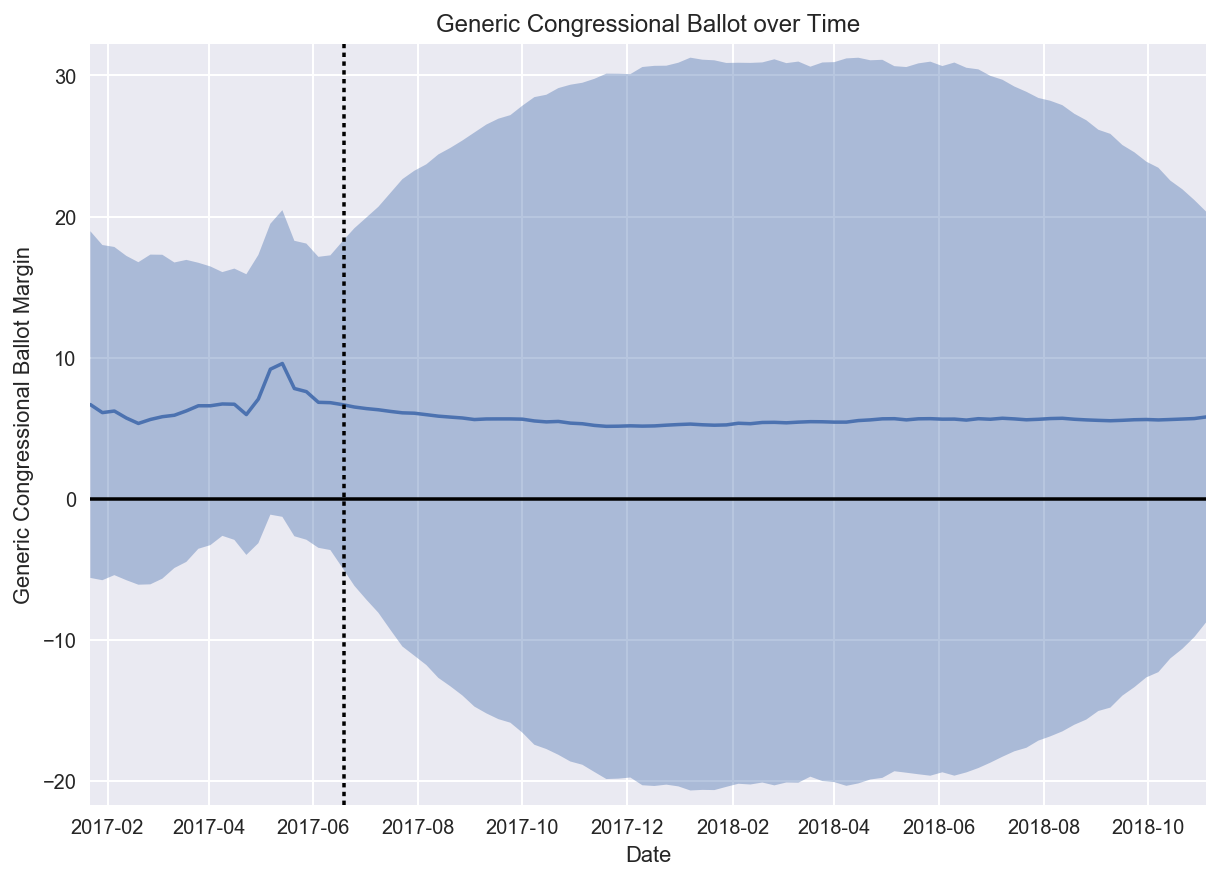

In [761]:
mu_samples = fit.extract("mu")["mu"]
y = 100 * np.mean(mu_samples, axis=0)
err = 100 * np.std(mu_samples, axis=0)
weeks = pd.date_range(end=election_day, periods=n_weeks, freq="W")

plt.figure(figsize=(10,7))
plt.plot(weeks, y)
plt.fill_between(weeks, y - 2*err, y + 2*err, alpha=0.4)
plt.title("Generic Congressional Ballot over Time")
plt.ylabel("Generic Congressional Ballot Margin")
plt.xlabel("Date")
plt.ylim(min(0, min(y-2*err))-1, max(0, max(y+2*err))+1)
plt.xlim(min(weeks), max(weeks))
plt.axvline(x=date.today(), c="k", ls=":")
plt.axhline(y=0, c="k")
pass

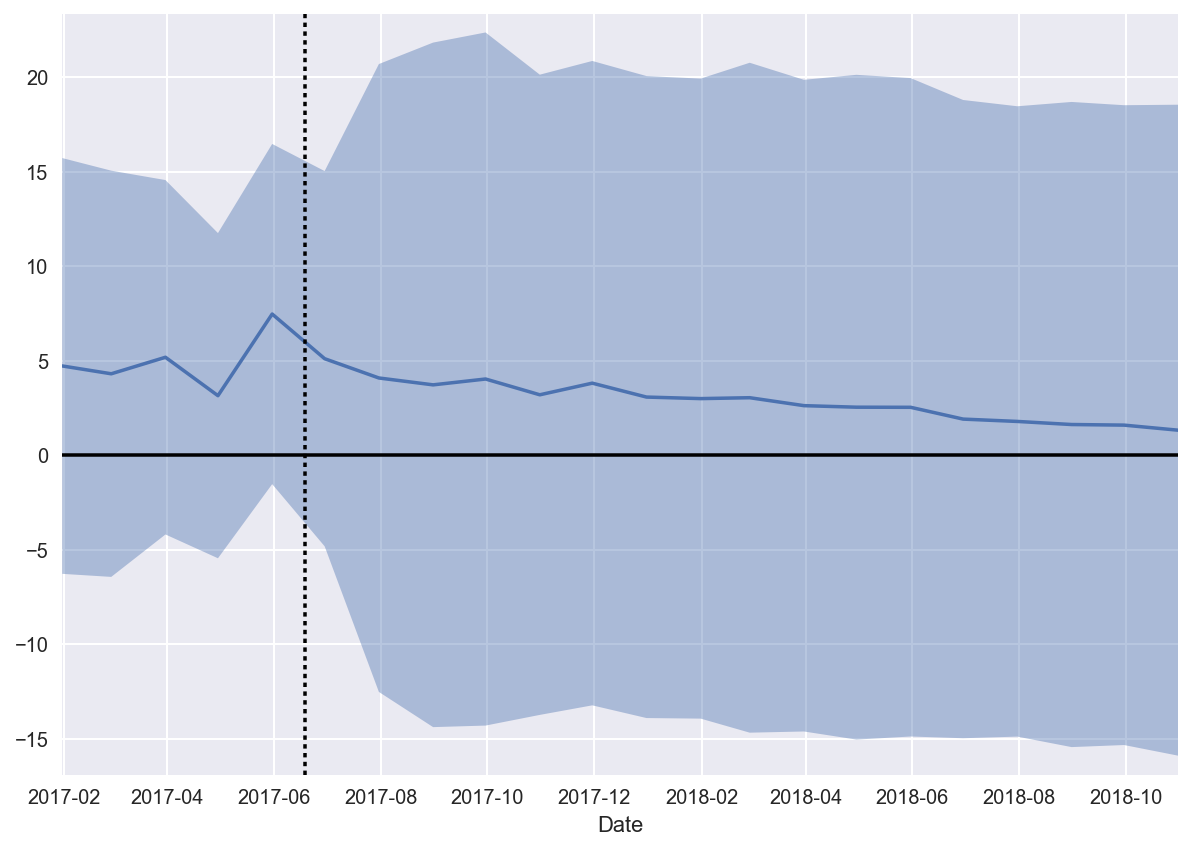

In [762]:
alpha_samples = fit.extract("alpha_n")["alpha_n"]
al = 100 * np.mean(alpha_samples, axis=0)
err_a = 2 * 100 * np.std(alpha_samples, axis=0)
months = pd.date_range(end=election_day, periods=n_months, freq="M")

plt.figure(figsize=(10,7))
plt.plot(months, al)
plt.fill_between(months, al - err_a, al + err_a, alpha=0.4)
plt.xlabel("Date")
plt.ylim(min(0, min(al-err_a))-1, max(0, max(al+err_a))+1)
plt.xlim(min(months), max(months))
plt.axvline(x=date.today(), c="k", ls=":")
plt.axhline(y=0, c="k")
pass

In [738]:
incumbents = get_incumbency()
not_running = find_not_running(2018)

In [770]:
race_prior_data = []
races = incumbents.district.unique()
for race in races:
    race_prior_data.append({ 
        "NAT": y[-1],
        "INC": 0 if race in not_running else incumbents.loc[race].incumbent,
        "PVI": cd_vote.loc[race].pvi_2018,
        "MID": 1,
        "PRES": -1,
    })

race_predictions = prior_model.predict(race_prior_data).values / 100

addl_var = (err[-1] / 100)**2
cov_matrix = np.full((435, 435), dist_cov + addl_var)
np.fill_diagonal(cov_matrix, dist_var + addl_var)

# Monte Carlo sim
N = 20_000

results = np.random.multivariate_normal(race_predictions, cov_matrix, N)

expected = results.mean(axis=0)
prob_district = np.mean((np.sign(results) + 1) / 2, axis=0)
seats = np.sum((np.sign(results) + 1) / 2, axis=1)
prob = np.mean(seats >= 218)
gain = np.mean(seats) - 194

Democrats have a 29% chance of retaking the House.
They are expected to gain 16 seats.


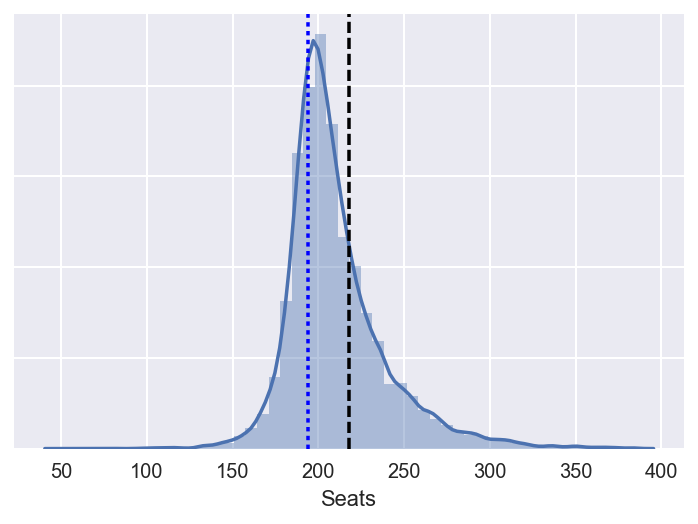

In [771]:
sb.distplot(seats)
plt.axvline(x=218, c="k", ls="--")
plt.axvline(x=194, c="b", ls=":")
plt.gca().yaxis.set_ticklabels([])
plt.xlabel("Seats")

print(f"Democrats have a {prob:.0%} chance of retaking the House.")
print(f"They are expected to {'gain' if gain > 0 else 'lose'} {abs(gain):.0f} seats.")

# References and Acknowledgements

Polling data from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api/v2).

Model based in part on Pierre-Antoine Kremp's [2016 presidential election model](http://www.slate.com/features/pkremp_forecast/report.html).